In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fastai imports
from fastai.vision import *

# import path to use path objects instead of strings
from pathlib import Path

In [37]:
! pwd

/home/titus/fastai/SATAI


In [4]:
path = Path('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000')
path_part1 = path/'HAM10000_images_part_1'
path_part2 = path/'HAM10000_images_part_2'
data_path = path/"HAM10000_metadata.csv"

In [12]:
help(get_image_files)

Help on function get_image_files in module fastai.vision.data:

get_image_files(c: Union[pathlib.Path, str], check_ext: bool = True, recurse=False) -> Collection[pathlib.Path]
    Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`.



#### Get images

Obtaining images from path 1

In [39]:
fnames_1 = get_image_files(path_part1)
fnames_1[:3]

[PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026902.jpg'),
 PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025846.jpg'),
 PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0025998.jpg')]

Obtaining images from path 2

In [40]:
fnames_2 = get_image_files(path_part2)
fnames_2[:3]

[PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0030678.jpg'),
 PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0033076.jpg'),
 PosixPath('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0032350.jpg')]

Joining images

In [41]:
fnames = fnames_1 + fnames_2

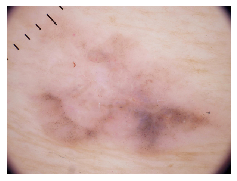

In [42]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(4,4))

In [5]:
df = pd.read_csv(data_path)
df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back


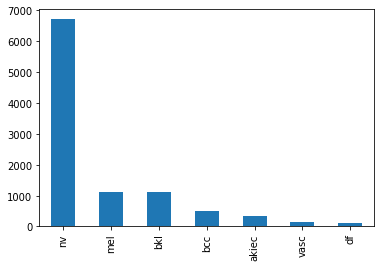

In [6]:
df['dx'].value_counts().plot(kind = 'bar')

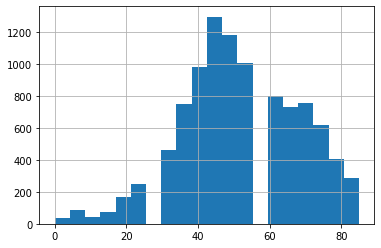

In [7]:
df['age'].hist(bins = 20)

We define the batch size and the size of the images

In [8]:
bs = 64
#bs = 32

size = 448

#### Transform

In [9]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
#data = (ImageItemList.from_folder("add_your_path_here") #Where to find the data? -> in path and its subfolders
#        .split_by_folder()              #How to split in train/valid? -> use the folders
#        .label_from_folder()            #How to label? -> depending on the folder of the filenames
#        .add_test_folder()              #Optionally add a test set (here default name is test)
#        .transform()       #Data augmentation? -> use tfms with a size of 64
#        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

In [ ]:
data = (ImageList.from_csv(path=path, 
                              csv_name='HAM10000_metadata.csv',
                              folder='train_images',
                              suffix='.dcm'
                             )
        .random_split_by_pct()
        .label_from_df(cols='Target')
        .transform(get_transforms(), size=224)
        .databunch())

In [56]:
data = ImageDataBunch.from_csv('/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000', csv_labels='HAM10000_metadata.csv', suffix='.jpg', fn_col=1, label_col=2, 
                               ds_tfms=tfms, valid_pct = 0.2,size=size, bs=bs)
print('Transforms = ', len(tfms))
# Save the DataBunch in case the training goes south... so you won't have to regenerate it..
# Remember: this DataBunch is tied to the batch size you selected. 
data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')
# Show the statistics of the Bunch...
print(data.classes)
data

FileNotFoundError: [Errno 2] No such file or directory: '/home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/ISIC_0027419.jpg'

In [10]:
data = ImageDataBunch.from_df(
    path = path/'images',    # path to images folder
    df = df,                 # dataframe
    suffix = '.jpg',         # image extension
    fn_col = 1,              # image_id column as name
    label_col = 2,           # dx as label
    ds_tfms=tfms,            # data augmentation
    size = size,             # image size
    bs = bs                  # batch size
)

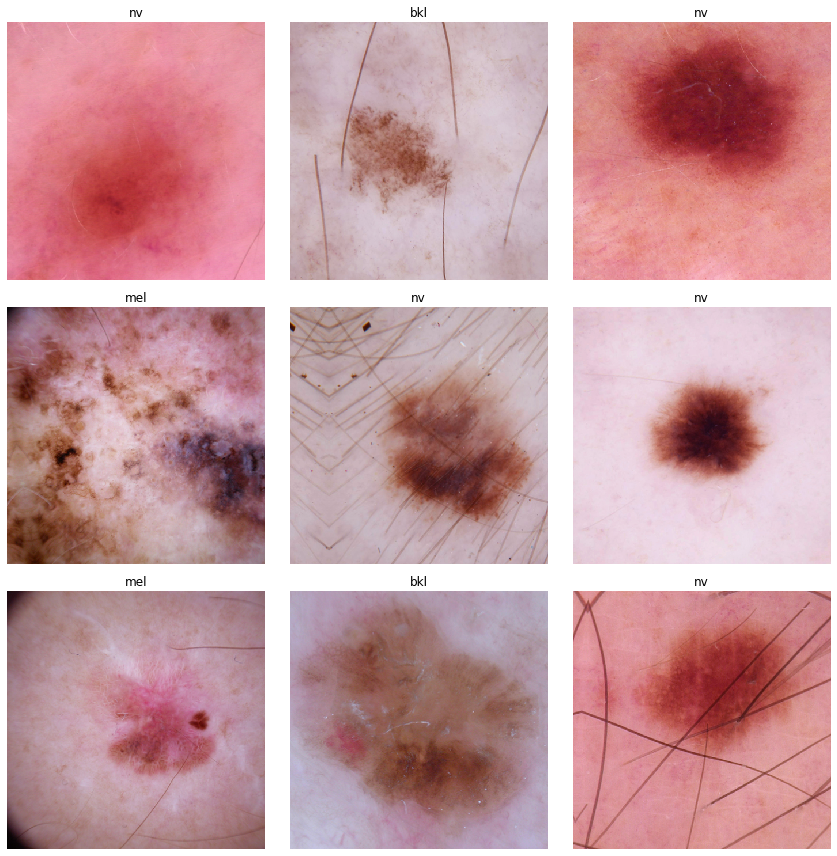

In [11]:
data.show_batch(rows=3)


In [60]:
! /usr/bin/nvidia-smi

Fri Nov 22 00:01:32 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.64       Driver Version: 430.64       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P8     7W /  N/A |    657MiB /  7982MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [12]:
data.normalize(imagenet_stats)  

ImageDataBunch;

Train: LabelList (8012 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
bkl,bkl,bkl,bkl,bkl
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/images;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
mel,nv,mel,nv,bcc
Path: /home/titus/fastai/SATAI/skin-cancer-mnist-ham10000/images;

Test: None

In [13]:
learner = cnn_learner(
    data, 
    models.resnet50, 
    metrics=[error_rate, Recall(), Precision(), FBeta(), MatthewsCorreff()], 
    path=path/'models'
)

In [14]:
learner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [15]:
learner.lr_find()
learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 7.80 GiB total capacity; 6.17 GiB already allocated; 315.69 MiB free; 67.99 MiB cached)